In [ ]:
!pip install numpy torch sympy mod blobfile pandas seaborn matplotlib tqdm einops wandb python-dotenv torchvision scipy

In [6]:
import os
from contextlib import suppress
from copy import deepcopy
from dataclasses import asdict, dataclass
from datetime import datetime
from typing import Callable, List, Literal, Optional, Tuple, Union

import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from matplotlib import cm, colors, gridspec
from matplotlib.colors import LogNorm
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST, VisionDataset
import wandb

from patterns.plotting import (BLUE, BLUES, RED, REDS, create_heatmap, plot,
                               plot_all_details, plot_details, plot_slice)
from patterns.sweep import (METRICS, exp_filter, extract_run,
                            extract_run_from_pivot, extract_slice,
                            extract_slice_from_pivot, get_history, get_pivot,
                            handle_outliers)


if os.getenv('USE_TQDM_NOTEBOOK', 'NO').lower() in ['yes', 'true', '1']:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

DEFAULT_MODULUS = 113
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sns.set_theme(style="darkgrid")
ENTITY = os.getenv('WANDB_ENTITY', None)

if ENTITY is None:
    raise ValueError('WANDB_ENTITY is not set')

# Interpolations

## Plots


In [7]:
def plot_interpolation_overview(
    df: pd.DataFrame,
    unique_col: str = "weight_decay",
    smooth: Union[bool, float] = False,
    cmap="inferno",
    log_loss=True,
    log_x: bool = True,
    log_y: bool = True,
    title: str = "",
    metric: str = "test/acc",
    metric_label: str = "Accuracy",
    run_vals: List[float] = [0.0],
    plot_extra: bool = False,
    latex: str = "",
    suptitle: str = "",
):
    metric_label_short = (
        metric_label.split(" ")[1] if " " in metric_label else metric_label
    )

    num_snapshots = len(run_vals)

    # create a figure with a 2x2 grid of subplots
    fig = plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(num_snapshots, 2, width_ratios=[3, 2], hspace=0.25)

    pivot_table = get_pivot(
        df, unique_col, reindex=True, interpolate=True, columns=[metric]
    )
    unique_vals = sorted(df[unique_col].unique())

    ax1 = plt.subplot(gs[:, 0])
    y = pivot_table[metric].index
    mesh = create_heatmap(
        x=unique_vals,
        y=y,
        z=pivot_table[metric].values,
        ax=ax1,
        smooth=smooth,
        cmap=cmap,
        log_x=log_x,
        log_y=log_y,
        log_z=log_loss and "loss" in metric,
        title=title,
    )

    fig.colorbar(mesh, ax=ax1, label=metric_label)

    # Plot horizontal lines at the run_vals entries
    run_vals_lines = [(v + 0.0125 if v == 0 else v) for v in run_vals]
    ax1.vlines(run_vals_lines, y.min(), y.max(), color=RED)

    # Find the _step for each run where the train/acc first reaches 1.0
    interpolation = []
    convergence = []

    for i, val in enumerate(unique_vals):
        run = df.loc[(df[unique_col] == val), :]

        interp_max = run["train/acc"].max()
        interp_threshold = interp_max * 0.95
        interp_step = run.loc[run["train/acc"] > interp_threshold, "_step"].min()  # type: ignore
        interp_val = run.loc[run._step == interp_step, "train/acc"].values[0]  # type: ignore
        interpolation.append((interp_step, interp_val))

        conv_max = run[metric].max()
        conv_threshold = conv_max * 0.95
        conv_step = run.loc[run[metric] > conv_threshold, "_step"].min()  # type: ignore
        conv_val = run.loc[run._step == conv_step, metric].values[0]  # type: ignore
        convergence.append((conv_step, conv_val))

    ax1.plot(
        unique_vals,
        [v for (v, _) in interpolation],
        color="grey",
        linestyle="--",
        label="Interpolation",
    )
    ax1.plot(
        unique_vals,
        [v for (v, _) in convergence],
        color="grey",
        linestyle="--",
        label="Convergence",
    )

    for i, val in enumerate(run_vals):
        run = df.loc[(df[unique_col] == val), :]
        ax = plt.subplot(gs[i, 1])

        # Interpolation threshold
        unique_val_idx = unique_vals.index(val)

        interp_step, interp_val = interpolation[unique_val_idx]
        ax.vlines(interp_step, 0, interp_val, color="grey", linestyle="--", label=None)

        # Test convergence threshold
        conv_step, conv_val = convergence[unique_val_idx]
        ax.vlines(conv_step, 0, conv_val, color="grey", linestyle="--", label=None)

        ax.plot(run._step, run["train/acc"], color=BLUE, label="Train")
        ax.plot(run._step, run[metric], color=RED, label="Test")

        val_rounded = round(val, 2)
        
        ax.set_ylim([0.0, 1.05])
        ax.set_xscale("log")
        ax.set_xlim([1e0, df._step.max()])

        if i < len(run_vals) - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("Step")

        ax_title = f"{metric_label_short} for ${latex}={val_rounded}$"
        ax.legend(title=ax_title, loc="lower right", title_fontsize=16, fontsize=14)

    plt.suptitle(suptitle)


In [8]:
# INTERP_SWEEPS = ["kodd01ka", "wecya83q", "wqnakkjd", "awxzpem1"]
INTERP_SWEEPS=["fyybk1tz"]
interp_sweep = get_history(*INTERP_SWEEPS, project="grokdd_fig1_sweep", allow_duplicates=True)
interp_sweep_backup = interp_sweep.copy()

In [9]:
lr_factors = interp_sweep.lr_factor.unique()

intep_sweep = interp_sweep_backup.copy()
interp_sweep_backup = interp_sweep.copy()

interp_sweep["test/acc"]

0       0.131737
0       0.089820
0       0.107784
0       0.101796
0       0.065868
          ...   
2980    0.502994
499     0.706587
2980    0.526946
2980    0.712575
2980    0.838323
Name: test/acc, Length: 22905, dtype: float64

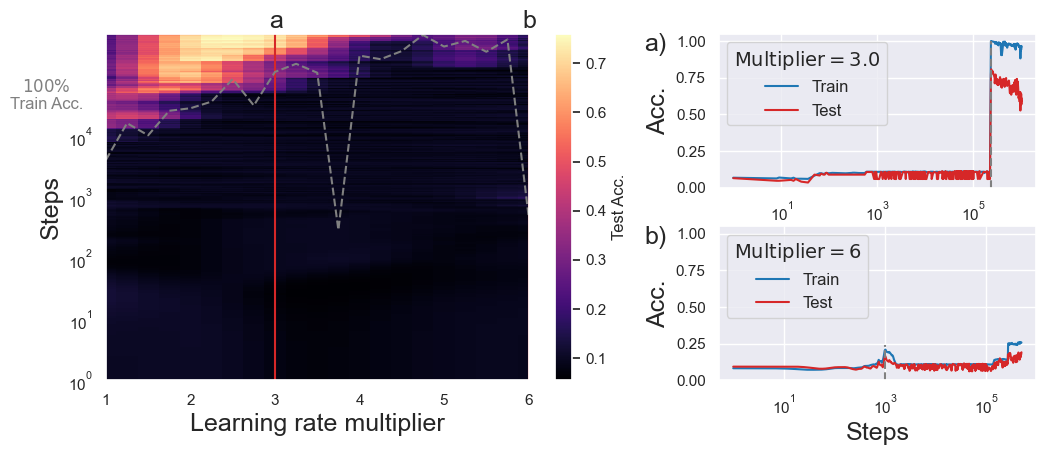

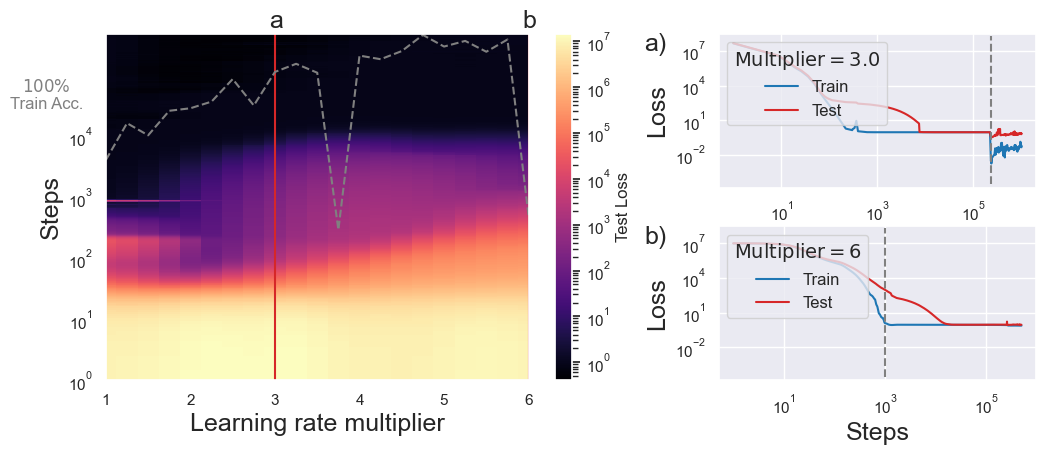

In [11]:
from scipy.ndimage import gaussian_filter, gaussian_filter1d


def plot_interpolation(
    df: pd.DataFrame,
    unique_col: str = "weight_decay",
    smooth: Union[bool, float] = False,
    cmap="inferno",
    log_loss=True,
    log_x: bool = True,
    log_y: bool = True,
    title: str = "",
    metric: str = "test/acc",
    metric_label: str = "Accuracy",
    run_vals: List[float] = [0.0],
    plot_extra: bool = False,
    latex: str = "",
    suptitle: str = "",
    figsize: Tuple[float, float] = (12, 6),
):
    metrics = METRICS[:-2]
    train_metric = metric.replace("test", "train")
    metric_label_short = (
        metric_label.split(" ")[1] if " " in metric_label else metric_label
    )

    num_snapshots = len(run_vals)

    # create a figure with a 2x2 grid of subplots
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(num_snapshots, 2, width_ratios=[5, 3], hspace=0.25)

    pivot_table = get_pivot(
        df, unique_col, reindex=True, interpolate=True, columns=metrics
    )
    unique_vals = sorted(df[unique_col].unique())

    ax1 = plt.subplot(gs[:, 0])
    y = pivot_table.loc[pivot_table.index < 500_000][metric].index
    
    if smooth:
        for m in metrics:
            _pivot_table = gaussian_filter(pivot_table[m], sigma=smooth)

            for i, unique_val in enumerate(unique_vals):
                pivot_table[(m, unique_val)] = _pivot_table[:, i]

    mesh = create_heatmap(
        x=unique_vals,
        y=y,
        z=pivot_table.loc[pivot_table.index<500_000][metric].values,
        ax=ax1,
        smooth=False,
        cmap=cmap,
        log_x=log_x,
        log_y=log_y,
        log_z=log_loss and ("loss" in metric),
        title=title,
    )
        
    ax1.set_ylabel("Steps", fontsize=18)
    ax1.set_xlabel(title, fontsize=18)
    fig.colorbar(mesh, ax=ax1, label=metric_label)

    # Plot horizontal lines at the run_vals entries
    run_vals_lines = [(v + 0.0125 if v == 0 else v) for v in run_vals]
    ax1.vlines(run_vals_lines, y.min(), y.max(), color=RED)

    # Find the _step for each run where the train/acc first reaches 1.0
    interpolation = []
    convergence = []

    interp_percent = 1.0

    for i, val in enumerate(unique_vals):
        run = df.loc[(df[unique_col] == val), :]

        interp_max = run["train/acc"].max()
        interp_threshold = interp_max * interp_percent
        interp_step = run.loc[run["train/acc"] >= interp_threshold, "_step"].min()  # type: ignore
        interp_val = run.loc[run._step == interp_step, "train/acc"].values[0]  # type: ignore
        interpolation.append((interp_step, interp_val))

        conv_max = run[metric].max()
        conv_threshold = conv_max * 0.95
        conv_step = run.loc[run[metric] > conv_threshold, "_step"].min()  # type: ignore
        conv_val = run.loc[run._step == conv_step, metric].values[0]  # type: ignore
        convergence.append((conv_step, conv_val))

    interpolation_smooth = gaussian_filter1d(np.array(interpolation), sigma=3.)

    ax1.plot(
        unique_vals,
        [v for (v, _) in interpolation_smooth],
        color="grey",
        linestyle="--",
        label="Interpolation",
    )
    # ax1.plot(
    #     unique_vals,
    #     [v for (v, _) in convergence],
    #     color="grey",
    #     linestyle="--",
    #     label="Convergence",
    # )
    ax1.text(
        0.3,
        50000,
        "$100\\%$\nTrain Acc.",
        fontsize=12,
        horizontalalignment="center",
        verticalalignment="center",
        color="grey",
    )

    for i, val in enumerate(run_vals):
        run = extract_run_from_pivot(pivot_table, val, smooth=False, metrics=metrics) # df.loc[(df[unique_col] == val), :]

        if i == 0:
            run = df.loc[(df[unique_col] == val), :]
        else:
            run = run.loc[run._step < 500_000]

        ax = plt.subplot(gs[i, 1])

        # Interpolation threshold
        unique_val_idx = unique_vals.index(val)


        # Test convergence threshold
        # conv_step, conv_val = convergence[unique_val_idx]
        # ax.vlines(conv_step, 0, conv_val, color="grey", linestyle="--", label=None)

        ax.plot(run._step, run[train_metric], color=BLUE, label="Train")
        ax.plot(run._step, run[metric], color=RED, label="Test")

        val_rounded = round(val, 2)

        interp_step, interp_val = interpolation[unique_val_idx]

        if "Acc" in metric_label:
            min_interp_val = 0
            ax.set_ylim(0.0, 1.05)
        else:
            min_loss, max_loss = min(df[metric].min(), df[train_metric].min()), max(df[metric].max(), df[train_metric].max())
            
            if log_loss:
                ax.set_ylim(min_loss * .5, max_loss + 0.5 * max_loss)
                ax.set_yscale("log")
            else:
                ax.set_ylim(-0.05, max_loss + 0.5 * max_loss)

            min_interp_val = min_loss
            interp_step, _ = interpolation[unique_val_idx]
            interp_val = max_loss

        ax.vlines(interp_step, min_interp_val, interp_val, color="grey", linestyle="--", label=None)

        # Plot "a" or "b" above the line on ax1
        line_label = "b" if i == 1 else "a"
        ax1.text(
            val + 0.0125,
            800000,
            line_label,
            fontsize=18,
            horizontalalignment="center",
            verticalalignment="center",
        )

        # Plot "a" or "b" at top-left of ax
        ax.text(
            -0.2,
            .93,
            line_label + ")",
            fontsize=18,
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
        )

        ax.set_xscale("log")
        # ax.set_xlim([1e0, df._step.max()])
        ax.set_ylabel(metric_label_short, fontsize=18)


        ax.set_xticks([10, 1000, 100000])
        if i >= len(run_vals) - 1:
            ax.set_xlabel("Steps", fontsize=18)

        ax_title = f"${latex}={val_rounded}$"
        ax.legend(title=ax_title, loc="upper left", fontsize=12, title_fontsize=14)

    plt.suptitle(suptitle)

    slug = title.lower().replace(" ", "-") + "-" + metric.lower().replace("/", "-")
    plt.savefig(f"../../figures/interpolation-{slug}.png", bbox_inches="tight")

def plot(**kwargs):
    plot_interpolation(
        interp_sweep,
        unique_col="lr_factor",  
        title="Learning rate multiplier",
        cmap="magma",
        latex=r"\mathrm{Multiplier}",
        log_x=False,
        suptitle="",
        metric_label="Test Acc.",
        **kwargs
    )   
    plt.show()

    plot_interpolation(
        interp_sweep,
        unique_col="lr_factor",  
        title="Learning rate multiplier",
        cmap="magma",
        latex=r"\mathrm{Multiplier}",
        log_x=False,
        suptitle="",
        metric="test/loss",
        metric_label="Test Loss",
        **kwargs
    )   
    plt.show()


plot(
    figsize=(12, 4.5),
    smooth=(10., 1.5),
    run_vals=[3., 6]
)

In [ ]:
plot(smooth=(10., 1.5), run_vals=[2.5, 5.5])

In [ ]:
ln_sweep = get_history("xwna3rhg", allow_duplicates=True)

# ln_sweep_cleaned = handle_outliers(
#     ln_sweep,
#     loss_cols=["train/loss"], 
#     action="keep",
#     unique_cols=["frac_train"],
#     threshold=0.0001,
#     late_epochs_ratio=0.6,
# )


def correct_label_noise(df: pd.DataFrame):
    # Correct the sweeps by dividing test/acc by 1-label_noise
    df = df.copy()

    lbl_noises = df.frac_label_noise.unique()

    for lbl_noise in lbl_noises:
        for metric in ["test/acc"]:
            df.loc[df.frac_label_noise==lbl_noise, metric] /= 1 - lbl_noise

    return df

ln_sweep_cleaned = correct_label_noise(ln_sweep)

In [ ]:
sns.lineplot(ln_sweep, x="_step", y="test/acc", hue="frac_label_noise", legend=False, palette="coolwarm", )
plt.xscale('log')
plt.xlabel("Steps")
plt.show()

sns.lineplot(ln_sweep_cleaned, x="_step", y="test/acc", hue="frac_label_noise", legend=False, palette="coolwarm", )
plt.xscale('log')
plt.xlabel("Steps")
plt.show()

In [ ]:
plot_interpolation_overview(
    ln_sweep_cleaned,
    unique_col="frac_label_noise",  
    title="Fraction training noise",
    cmap="coolwarm",
    run_vals=[0.0, 0.05, 0.15],
    latex=r"f_\mathrm{noise}",
    log_x=False,
    suptitle="Modular Arithmetic"
)   

In [ ]:
frac_train_sweep = get_history("cnr2n43n", "759uhy5f", allow_duplicates=True, project="mnist-grokking")

In [ ]:
ft_vals = sorted(frac_train_sweep.frac_train.unique())
ft_selection = [ft_vals[-3], ft_vals[8], ft_vals[1]]

plot_interpolation_overview(
    frac_train_sweep,
    unique_col="frac_train",
    title="Training Fraction",
    cmap="coolwarm",
    run_vals=ft_selection,
    latex=r"f_\mathrm{train}",
    log_x=True,
    suptitle="MNIST"
) 

In [ ]:
api = wandb.Api()
mnist_dd = api.run(f"{ENTITY}/mnist-grokking/hbw3nlnb")
mnist_grok = api.run(f"{ENTITY}/mnist-grokking/9i790lal")

mnist_dd_df = pd.DataFrame(mnist_dd.history())
mnist_grok_df = pd.DataFrame(mnist_grok.history())

In [ ]:
# 2 by 2 grid of subplots
# Acc on left, loss on right
# DD on top, Grokking on bottom
# Train in blue, test in red

fig, axes = plt.subplots(2, 2, figsize=(10, 6))

for i, (df, title) in enumerate(zip([mnist_dd_df, mnist_grok_df], ["DD", "Grokking"])):
    ax = axes[i, 0]
    # Sort by steps
    df = df.sort_values("_step")

    ax.plot(df._step, df["train/acc"], color=BLUE, label="Train")
    ax.plot(df._step, df["test/acc"], color=RED, label="Test")
    ax.set_title(f"{title} Accuracy")
    ax.set_ylim([0., 1.05])
    ax.set_xscale("log")
    ax.set_xlim([1e0, df._step.max()])
    ax.legend(loc="lower right")

    ax = axes[i, 1]
    ax.plot(df._step, df["train/loss"], color=BLUE, label="Train")
    ax.plot(df._step, df["test/loss"], color=RED, label="Test")
    ax.set_title(f"{title} Loss")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim([1e0, df._step.max()])
    ax.legend(loc="upper right")

# More space between rows
fig.tight_layout(pad=1.5)
